<h2><b>Exploring different baseline prediction models</b></h2>
<p>- Konark Verma</p>

In this notebook we will explore the following models:<br>
<ol>
<li>Naive Prediction Model</li>
<li>Moving Average Prediction Model</li>
</ol>

These models help us give a baseline error for our problem, so that we can further build on it.

In [1]:
# Importing the required libraries.
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

In [34]:
# Function to plot series.
def plot_series(time, series, format="-", start=0, end=None, label=None):
    if label:
        plt.plot(time[start:end], series[start:end], format, label=label)
    else:
        plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

# Functions to generate trend, seasonality and white noise.
def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

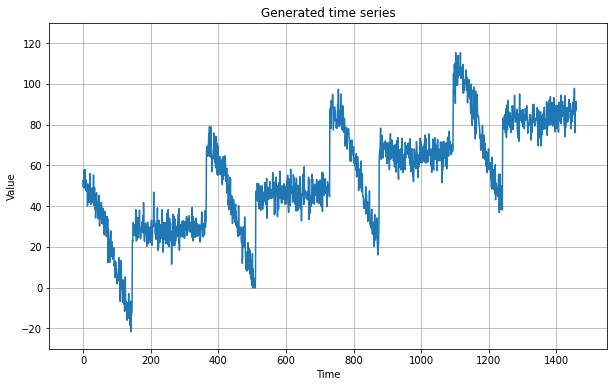

In [35]:
# Parameters for generating a time series.
time = np.arange(4*365, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Generating a time series and plotting it.
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude) + noise(time, noise_level, seed=42)
plt.figure(figsize=(10, 6))
plt.title('Generated time series')
plt.xlim(-100,1550)
plt.ylim(-30,130)
plot_series(time, series)
plt.show()

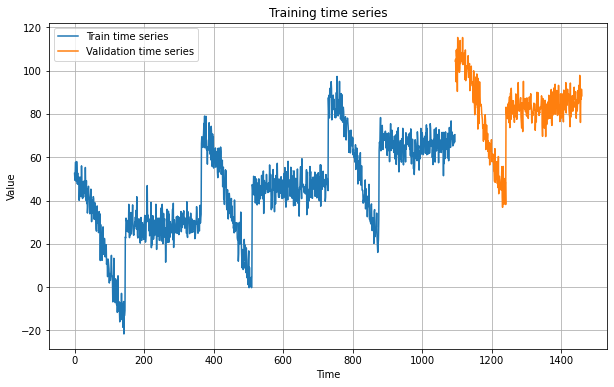

In [38]:
# Splitting the time series into training and validation series.
split_time = 365*3
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

# Plotting the training and validation time series.
plt.figure(figsize=(10, 6))
plt.title('Training time series')
plot_series(time_train, x_train, label='Train time series')
plot_series(time_valid, x_valid, label='Validation time series')
plt.legend()
plt.show()

----
<h3><b>1. Naive Prediction Model</b></h3>
<p>In Naive prediction model, we just predict the value at time 't' equal to the value at time 't-1'.</p>

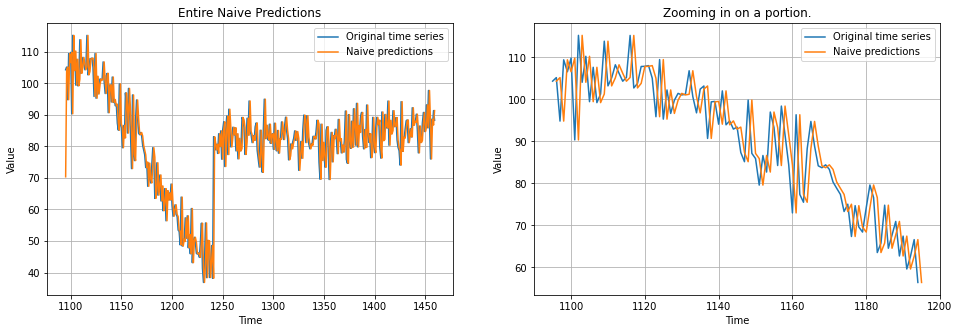



Metrics for Naive Prediction Model :
	Mean Squared Error : 62.58
	Mean Absolute Error : 6.01


In [51]:
# Naive Predictions
naive_forecast = series[split_time-1:-1]

# Plotting the graph for Naive predictions.
plt.figure(figsize=(16, 5))
plt.subplot(121)
plt.title('Entire Naive Predictions')
plot_series(time_valid, x_valid, label='Original time series')
plot_series(time_valid, naive_forecast, label='Naive predictions')
plt.legend()
plt.subplot(122)
plt.title('Zooming in on a portion.')
plot_series(time_valid, x_valid, start=0, end=100, label='Original time series')
plot_series(time_valid, naive_forecast, start=1, end=101, label='Naive predictions')
plt.legend()
plt.show()

# Calculating the mean-squared-error and mean-absolute-error.
print('\n\nMetrics for Naive Prediction Model on Validation time series:')
print('\tMean Squared Error :', np.round(keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy(),2))
print('\tMean Absolute Error :', np.round(keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy(),2))

----
<h3><b>2. Moving Average Prediction Model</b></h3>
<p>In Moving Average prediction model, we predict the value at time 't' by taking the average of a fixed number of previous values.</p>

In [53]:
# Function to calculate the moving average.
def moving_average_forecast(series, window_size):
    forecast = []
    for time in range(len(series) - window_size):
        forecast.append(series[time:time+window_size].mean())
    return np.array(forecast)

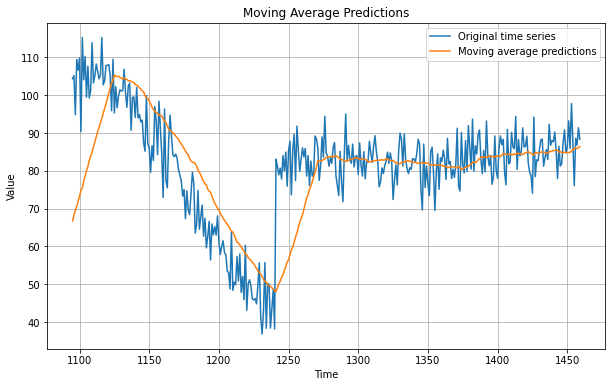



Metrics for Moving Average Prediction Model:
	Mean Squared Error : 124.99
	Mean Absolute Error : 7.91


In [54]:
# Prediction using moving average over past 30 values.
moving_avg = moving_average_forecast(series, 30)[split_time-30:]

# Plotting the graph for predictions.
plt.figure(figsize=(10, 6))
plt.title('Predictions using only moving average')
plot_series(time_valid, x_valid, label='Original time series')
plot_series(time_valid, moving_avg, label='Moving average predictions')
plt.legend()
plt.show()

# Calculating the mean-squared-error and mean-absolute-error.
print('\n\nMetrics for Moving Average Prediction Model:')
print('\tMean Squared Error :', np.round(keras.metrics.mean_squared_error(x_valid, moving_avg).numpy(),2))
print('\tMean Absolute Error :', np.round(keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy(),2))

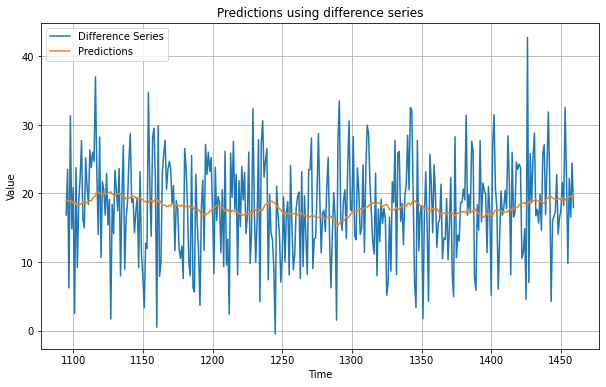

In [61]:
# Generating the difference graph.
diff_series = (series[365:]-series[:-365])
diff_time = time[365:]

# Forecasting using the difference series.
diff_moving_avg = moving_average_forecast(diff_series, 50)[split_time - 365 - 50:]
plt.figure(figsize=(10, 6))
plt.title('Predictions using difference series')
plot_series(time_valid, diff_series[split_time - 365:], label='Difference Series')
plot_series(time_valid, diff_moving_avg, label='Predictions')
plt.legend()
plt.show()


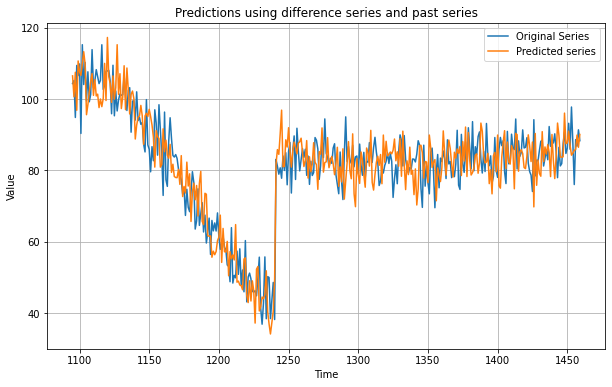



Metrics for Moving Average Prediction Model:
	Mean Squared Error : 53.51
	Mean Absolute Error : 5.85


In [63]:
# Forecasting using difference series and past series.
diff_moving_avg_plus_past = series[split_time - 365:-365] + diff_moving_avg
plt.figure(figsize=(10, 6))
plt.title('Predictions using difference series and past series')
plot_series(time_valid, x_valid, label='Original Series')
plot_series(time_valid, diff_moving_avg_plus_past, label='Predicted series')
plt.legend()
plt.show()

# Calculating the mean-squared-error and mean-absolute-error.
print('\n\nMetrics for Moving Average Prediction Model:')
print('\tMean Squared Error :', np.round(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_past).numpy(),2))
print('\tMean Absolute Error :', np.round(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy(),2))

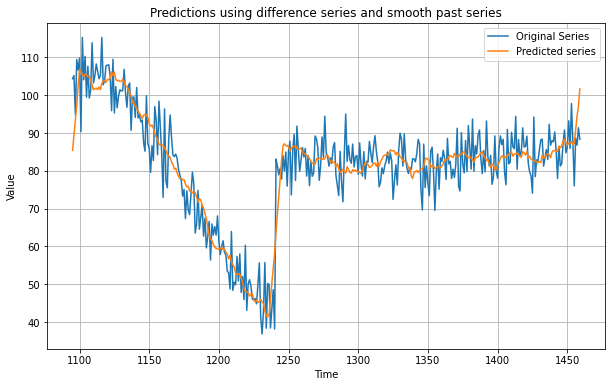



Metrics for Difference series and Smooth past series:
	Mean Squared Error : 34.0
	Mean Absolute Error : 4.62


In [64]:
# Forecasting using difference series and smoothened past series.
diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time - 370:-360], 10) + diff_moving_avg
plt.figure(figsize=(10, 6))
plt.title('Predictions using difference series and smooth past series')
plot_series(time_valid, x_valid, label='Original Series')
plot_series(time_valid, diff_moving_avg_plus_smooth_past, label='Predicted series')
plt.legend()
plt.show()

# Calculating the mean-squared-error and mean-absolute-error.
print('\n\nMetrics for Difference series and Smooth past series:')
print('\tMean Squared Error :', np.round(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_smooth_past).numpy(),2))
print('\tMean Absolute Error :', np.round(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past).numpy(),2))

----